Modelling Before Scaling

In [1]:
# Base Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import time
from collections import defaultdict

# Data Analysis Libraries
from sklearn.base import clone
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFE, SelectKBest, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler,StandardScaler, RobustScaler, MaxAbsScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.metrics import mean_squared_error,accuracy_score,recall_score,precision_score,f1_score,roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedStratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
import xgboost as xgb
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
csv_file = 'CICDDoS-Real/cicddos2019_cleaned.csv'
df = pd.read_csv(csv_file, low_memory=False)
df.shape

(360000, 88)

In [3]:
# Mengacak seluruh baris DataFrame
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

### Informasi Dataset

In [4]:
#info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 88 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Flow ID                      360000 non-null  object 
 2   Source IP                    360000 non-null  object 
 3   Source Port                  360000 non-null  int64  
 4   Destination IP               360000 non-null  object 
 5   Destination Port             360000 non-null  int64  
 6   Protocol                     360000 non-null  int64  
 7   Timestamp                    360000 non-null  object 
 8   Flow Duration                360000 non-null  int64  
 9   Total Fwd Packets            360000 non-null  int64  
 10  Total Backward Packets       360000 non-null  int64  
 11  Total Length of Fwd Packets  360000 non-null  float64
 12  Total Length of Bwd Packets  360000 non-null  float64
 13 

In [5]:
#Bagian awal dataset
df.head()

,Unnamed: 0,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,SimillarHTTP,Inbound,Label
0,28102,172.16.0.5-192.168.50.1-553-11930-17,172.16.0.5,553,192.168.50.1,11930,17,2018-12-01 11:23:04.133911,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_LDAP
1,17675,172.16.0.5-192.168.50.1-997-4051-17,172.16.0.5,997,192.168.50.1,4051,17,2018-12-01 11:32:18.205323,2,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_LDAP
2,661545,172.16.0.5-192.168.50.1-27238-3411-6,172.16.0.5,27238,192.168.50.1,3411,6,2018-12-01 13:31:10.155752,1,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Syn
3,688385,172.16.0.5-192.168.50.1-36181-39435-6,172.16.0.5,36181,192.168.50.1,39435,6,2018-12-01 13:30:48.279274,51,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,Syn
4,16016,172.16.0.5-192.168.50.1-35261-14404-17,172.16.0.5,35261,192.168.50.1,14404,17,2018-12-01 13:02:49.155721,105961,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,DrDoS_UDP


In [6]:
df.describe()

,Unnamed: 0,Source Port,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound
count,360000.000000,360000.000000,360000.000000,360000.000000,3.600000e+05,360000.000000,360000.000000,3.600000e+05,3.600000e+05,360000.000000,...,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,3.600000e+05,360000.000000
mean,91493.758128,26078.477756,30912.601833,14.700269,2.200160e+06,8.975250,0.585044,3.733058e+03,3.847677e+02,582.758328,...,-3.609785e+07,7.325171e+03,2.620700e+03,1.084865e+04,5.733338e+03,6.801519e+05,1.105356e+05,8.047233e+05,5.820746e+05,0.930525
std,135889.709116,25364.107740,20110.524442,4.502866,1.275317e+07,250.280517,12.328315,3.287519e+04,3.131816e+04,544.547707,...,1.925211e+08,1.685573e+05,7.402011e+04,2.224704e+05,1.570655e+05,4.457633e+06,1.025535e+06,5.103451e+06,4.112389e+06,0.254261
min,0.000000,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,-1.408238e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,11986.000000,771.000000,13028.000000,17.000000,1.000000e+00,2.000000,0.000000,4.580000e+02,0.000000e+00,229.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
50%,38063.500000,21346.500000,30909.000000,17.000000,2.000000e+00,2.000000,0.000000,1.088000e+03,0.000000e+00,415.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
75%,106306.000000,52107.250000,48665.000000,17.000000,1.821250e+03,4.000000,0.000000,2.944000e+03,0.000000e+00,1035.000000,...,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000
max,805151.000000,65534.000000,65535.000000,17.000000,1.200000e+08,86220.000000,4602.000000,1.526642e+07,8.818824e+06,32120.000000,...,1.480000e+03,1.721058e+07,2.284064e+07,4.358468e+07,1.310114e+07,1.058368e+08,6.600292e+07,1.058368e+08,1.058368e+08,1.000000


In [7]:
df['Label'].value_counts()

Label
DrDoS_LDAP       30000
Syn              30000
DrDoS_UDP        30000
DrDoS_NetBIOS    30000
DrDoS_MSSQL      30000
DrDoS_DNS        30000
DrDoS_SSDP       30000
DrDoS_SNMP       30000
DrDoS_NTP        30000
TFTP             30000
UDP-lag          30000
BENIGN           30000
Name: count, dtype: int64

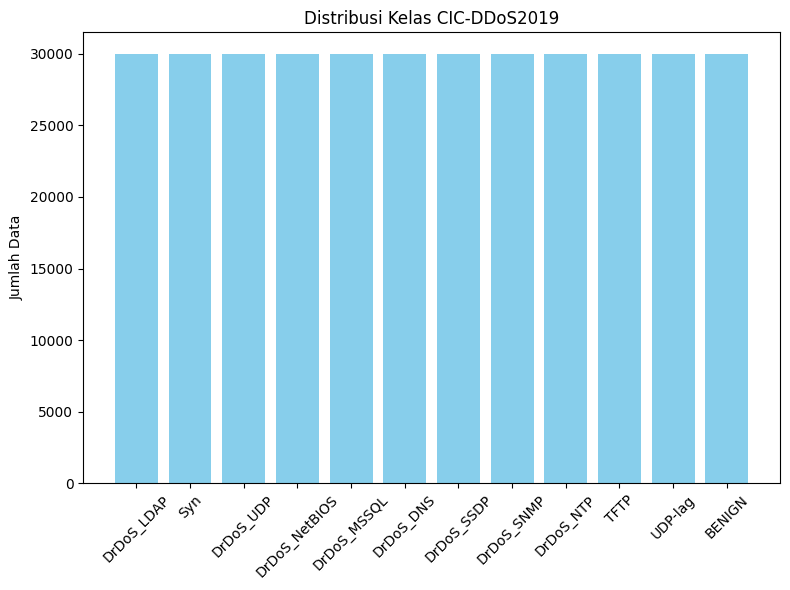

In [8]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat bar chart
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.ylabel('Jumlah Data')
plt.title('Distribusi Kelas CIC-DDoS2019')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

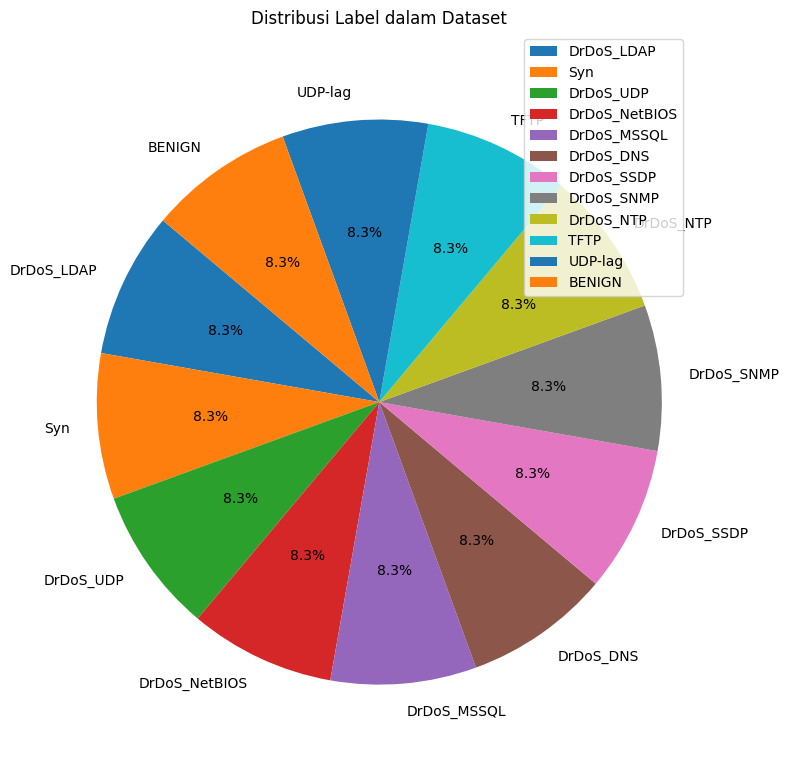

In [9]:
# Hitung jumlah masing-masing label
label_counts = df['Label'].value_counts()

# Buat pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.legend()
plt.title('Distribusi Label dalam Dataset')
plt.axis('equal')  # Agar bentuk pie-nya bulat
plt.tight_layout()
plt.show()

In [10]:
# Menampilkan jumlah sample tiap protocol. '17' = UDP. '6' = TCP. '0' = HOPOPT (IPv6 Hop-by-Hop Option)
df['Protocol'].value_counts()

Protocol
17    285251
6      73805
0        944
Name: count, dtype: int64

### Drop and Encoding Label

In [11]:
df = df.drop(['Flow ID', 'Source IP', 'Destination IP', 'Source Port', 'Destination Port', 'Timestamp', 'SimillarHTTP', 'Fwd Header Length.1'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360000 entries, 0 to 359999
Data columns (total 80 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   360000 non-null  int64  
 1   Protocol                     360000 non-null  int64  
 2   Flow Duration                360000 non-null  int64  
 3   Total Fwd Packets            360000 non-null  int64  
 4   Total Backward Packets       360000 non-null  int64  
 5   Total Length of Fwd Packets  360000 non-null  float64
 6   Total Length of Bwd Packets  360000 non-null  float64
 7   Fwd Packet Length Max        360000 non-null  float64
 8   Fwd Packet Length Min        360000 non-null  float64
 9   Fwd Packet Length Mean       360000 non-null  float64
 10  Fwd Packet Length Std        360000 non-null  float64
 11  Bwd Packet Length Max        360000 non-null  float64
 12  Bwd Packet Length Min        360000 non-null  float64
 13 

In [12]:
# Pengubahan nilai dari string (kategorikal) ke numerik
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])

label_mapping = pd.DataFrame({
    'Original Label': le.classes_,
    'Encoded Value': range(len(le.classes_))
})

print("Mapping of original labels to encoded values:")
print(label_mapping)

Mapping of original labels to encoded values:
   Original Label  Encoded Value
0          BENIGN              0
1       DrDoS_DNS              1
2      DrDoS_LDAP              2
3     DrDoS_MSSQL              3
4       DrDoS_NTP              4
5   DrDoS_NetBIOS              5
6      DrDoS_SNMP              6
7      DrDoS_SSDP              7
8       DrDoS_UDP              8
9             Syn              9
10           TFTP             10
11        UDP-lag             11


In [13]:
# Menampilkan sampel data setelah encoding (sudah bernilai numerikal)
df.loc[:,['Label']].head()

,Label
0,2
1,2
2,9
3,9
4,8


### X dan Y

In [14]:
X = df.drop(['Label'], axis=1)
y = df['Label']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Modeling Before Standarization

In [16]:
def evaluate_model(model, X_test, y_test, name="Model"):
    # Waktu prediksi
    start_pred = time.time()
    y_pred = model.predict(X_test)
    end_pred = time.time()
    prediction_time = end_pred - start_pred
    print(f"Waktu prediksi ({name}): {prediction_time:.4f} detik")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    # Classification report
    print(classification_report(y_test, y_pred, zero_division=0))

##### Gradient Boost

Waktu pelatihan (Gradient Boosting): 956.4523 detik
Waktu prediksi (Gradient Boosting): 2.8073 detik


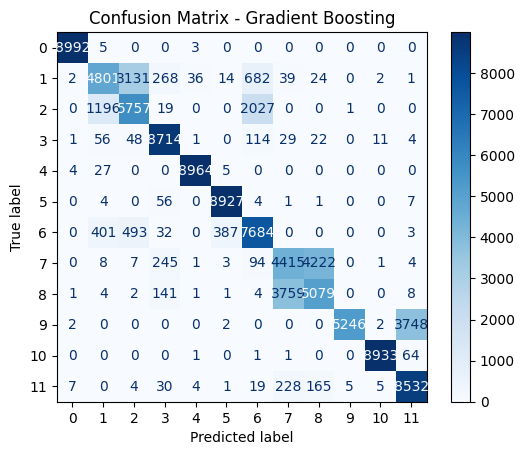

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.74      0.53      0.62      9000
           2       0.61      0.64      0.62      9000
           3       0.92      0.97      0.94      9000
           4       0.99      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.72      0.85      0.78      9000
           7       0.52      0.49      0.51      9000
           8       0.53      0.56      0.55      9000
           9       1.00      0.58      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.95      0.80      9000

    accuracy                           0.80    108000
   macro avg       0.81      0.80      0.79    108000
weighted avg       0.81      0.80      0.79    108000



In [34]:
# GBC
start_train = time.time()

gbc = GradientBoostingClassifier(random_state=42)
gbc.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Gradient Boosting): {training_time:.4f} detik")

evaluate_model(gbc, X_test, y_test, name="Gradient Boosting")

##### MLP

Iteration 1, loss = 23.12315089
Iteration 2, loss = 19.56404434
Iteration 3, loss = 18.76607304
Iteration 4, loss = 18.13296056
Iteration 5, loss = 17.79990799
Iteration 6, loss = 17.35976286
Iteration 7, loss = 16.93664938
Iteration 8, loss = 17.03720074
Iteration 9, loss = 16.66415257
Iteration 10, loss = 16.67599211
Iteration 11, loss = 16.56099081
Iteration 12, loss = 16.28505692
Iteration 13, loss = 16.18096659
Iteration 14, loss = 16.26717774
Iteration 15, loss = 16.11279576
Iteration 16, loss = 16.04384559
Iteration 17, loss = 16.17538136
Iteration 18, loss = 15.92727068
Iteration 19, loss = 15.94054717
Iteration 20, loss = 15.99265315
Iteration 21, loss = 16.23330774
Iteration 22, loss = 15.65990995
Iteration 23, loss = 15.72908136
Iteration 24, loss = 15.64245323
Iteration 25, loss = 15.64759936
Iteration 26, loss = 16.12178829
Iteration 27, loss = 15.55044054
Iteration 28, loss = 15.13332675
Iteration 29, loss = 15.38110838
Iteration 30, loss = 15.05248261
Iteration 31, loss 

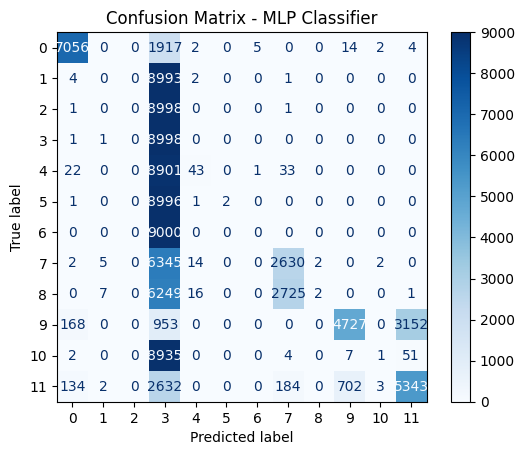

              precision    recall  f1-score   support

           0       0.95      0.78      0.86      9000
           1       0.00      0.00      0.00      9000
           2       0.00      0.00      0.00      9000
           3       0.11      1.00      0.20      9000
           4       0.55      0.00      0.01      9000
           5       1.00      0.00      0.00      9000
           6       0.00      0.00      0.00      9000
           7       0.47      0.29      0.36      9000
           8       0.50      0.00      0.00      9000
           9       0.87      0.53      0.65      9000
          10       0.12      0.00      0.00      9000
          11       0.62      0.59      0.61      9000

    accuracy                           0.27    108000
   macro avg       0.43      0.27      0.22    108000
weighted avg       0.43      0.27      0.22    108000



In [36]:
# MLPClassifier
start_train = time.time()

mlp = MLPClassifier(verbose=True)

mlp.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (MLP Classifier): {training_time:.4f} detik")

evaluate_model(mlp, X_test, y_test, name="MLP Classifier")

Iteration 1, loss = 16.21728866
Validation score: 0.307341
Iteration 2, loss = 5.20789546
Validation score: 0.249087
Iteration 3, loss = 3.95789184
Validation score: 0.233175
Iteration 4, loss = 3.78300996
Validation score: 0.207103
Iteration 5, loss = 3.70486370
Validation score: 0.205040
Iteration 6, loss = 3.59664877
Validation score: 0.180595
Iteration 7, loss = 3.23082955
Validation score: 0.093730
Iteration 8, loss = 2.47109564
Validation score: 0.092183
Iteration 9, loss = 2.46276546
Validation score: 0.095833
Iteration 10, loss = 2.46206057
Validation score: 0.095000
Iteration 11, loss = 2.46325677
Validation score: 0.085556
Iteration 12, loss = 2.48449299
Validation score: 0.086111
Validation score did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.
Waktu pelatihan (MLP Classifier): 43.7637 detik
Waktu prediksi (MLP Classifier): 0.3288 detik


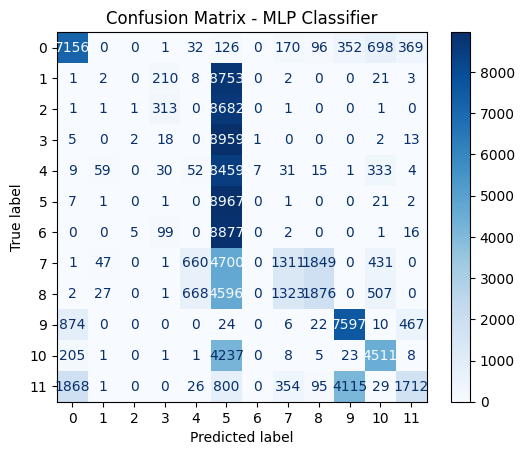

              precision    recall  f1-score   support

           0       0.71      0.80      0.75      9000
           1       0.01      0.00      0.00      9000
           2       0.12      0.00      0.00      9000
           3       0.03      0.00      0.00      9000
           4       0.04      0.01      0.01      9000
           5       0.13      1.00      0.24      9000
           6       0.00      0.00      0.00      9000
           7       0.41      0.15      0.21      9000
           8       0.47      0.21      0.29      9000
           9       0.63      0.84      0.72      9000
          10       0.69      0.50      0.58      9000
          11       0.66      0.19      0.30      9000

    accuracy                           0.31    108000
   macro avg       0.33      0.31      0.26    108000
weighted avg       0.33      0.31      0.26    108000



In [26]:
# MLPClassifier
start_train = time.time()

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate_init=0.001,
    max_iter=500,
    early_stopping=True,
    random_state=42,
    verbose=True
)

mlp.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (MLP Classifier): {training_time:.4f} detik")

evaluate_model(mlp, X_test, y_test, name="MLP Classifier")

##### KNN

Waktu pelatihan (KNN): 0.1165 detik
Waktu prediksi (KNN): 25.7877 detik


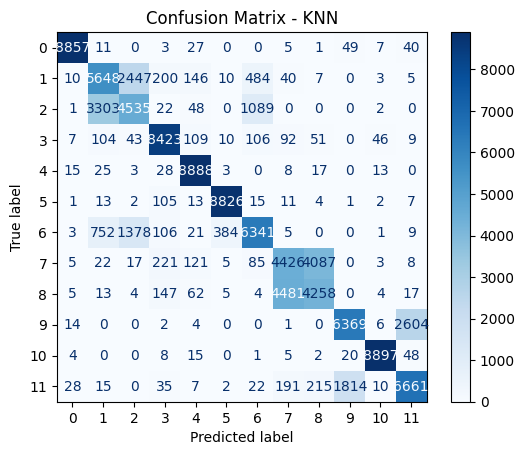

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      9000
           1       0.57      0.63      0.60      9000
           2       0.54      0.50      0.52      9000
           3       0.91      0.94      0.92      9000
           4       0.94      0.99      0.96      9000
           5       0.95      0.98      0.97      9000
           6       0.78      0.70      0.74      9000
           7       0.48      0.49      0.48      9000
           8       0.49      0.47      0.48      9000
           9       0.77      0.71      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.71      0.74      0.72      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [17]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model(knn, X_test, y_test, name="KNN")

Waktu pelatihan (KNN): 0.1156 detik
Waktu prediksi (KNN): 21.8239 detik


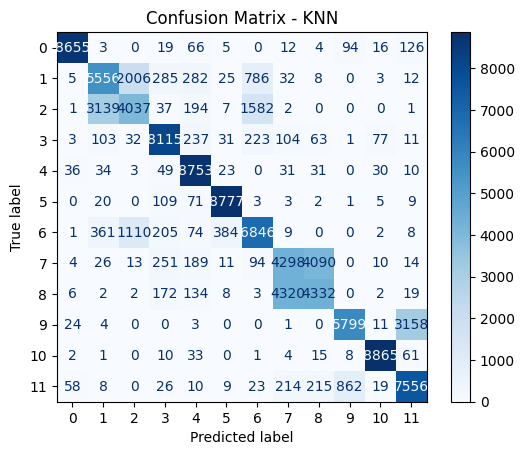

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      9000
           1       0.60      0.62      0.61      9000
           2       0.56      0.45      0.50      9000
           3       0.87      0.90      0.89      9000
           4       0.87      0.97      0.92      9000
           5       0.95      0.98      0.96      9000
           6       0.72      0.76      0.74      9000
           7       0.48      0.48      0.48      9000
           8       0.49      0.48      0.49      9000
           9       0.86      0.64      0.74      9000
          10       0.98      0.98      0.98      9000
          11       0.69      0.84      0.76      9000

    accuracy                           0.76    108000
   macro avg       0.75      0.76      0.75    108000
weighted avg       0.75      0.76      0.75    108000



In [27]:
# KNN
start_train = time.time()

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (KNN): {training_time:.4f} detik")

evaluate_model(knn, X_test, y_test, name="KNN")

##### Logistic Regression

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Waktu pelatihan (Logistic Regression): 1063.5726 detik
Waktu prediksi (Logistic Regression): 0.0450 detik


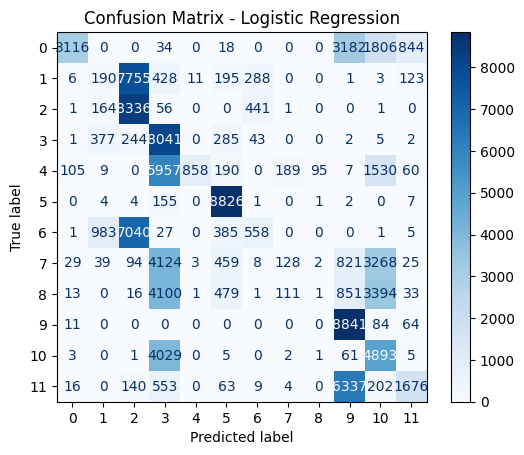

              precision    recall  f1-score   support

           0       0.94      0.35      0.51      9000
           1       0.11      0.02      0.04      9000
           2       0.35      0.93      0.51      9000
           3       0.29      0.89      0.44      9000
           4       0.98      0.10      0.17      9000
           5       0.81      0.98      0.89      9000
           6       0.41      0.06      0.11      9000
           7       0.29      0.01      0.03      9000
           8       0.01      0.00      0.00      9000
           9       0.44      0.98      0.61      9000
          10       0.32      0.54      0.40      9000
          11       0.59      0.19      0.28      9000

    accuracy                           0.42    108000
   macro avg       0.46      0.42      0.33    108000
weighted avg       0.46      0.42      0.33    108000



In [22]:
# Logistic Regression
start_train = time.time()

logreg = LogisticRegression(max_iter=9000, solver='lbfgs')
logreg.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Logistic Regression): {training_time:.4f} detik")

evaluate_model(logreg, X_test, y_test, name="Logistic Regression")

##### SVM

Waktu pelatihan (SVM): 7134.2054 detik
Waktu prediksi (SVM): 2154.2251 detik


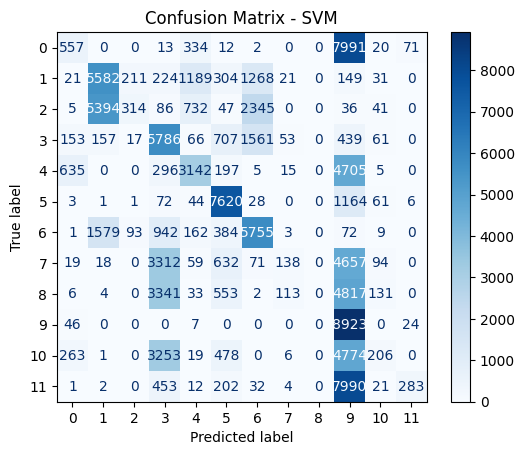

              precision    recall  f1-score   support

           0       0.33      0.06      0.10      9000
           1       0.44      0.62      0.51      9000
           2       0.49      0.03      0.07      9000
           3       0.33      0.64      0.43      9000
           4       0.54      0.35      0.42      9000
           5       0.68      0.85      0.76      9000
           6       0.52      0.64      0.57      9000
           7       0.39      0.02      0.03      9000
           8       0.00      0.00      0.00      9000
           9       0.20      0.99      0.33      9000
          10       0.30      0.02      0.04      9000
          11       0.74      0.03      0.06      9000

    accuracy                           0.35    108000
   macro avg       0.41      0.35      0.28    108000
weighted avg       0.41      0.35      0.28    108000



In [18]:
# SVM
start_train = time.time()

svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (SVM): {training_time:.4f} detik")

evaluate_model(svm, X_test, y_test, name="SVM")

##### Naive Bayes

Waktu pelatihan (Naive Bayes): 0.3698 detik
Waktu prediksi (Naive Bayes): 0.8028 detik


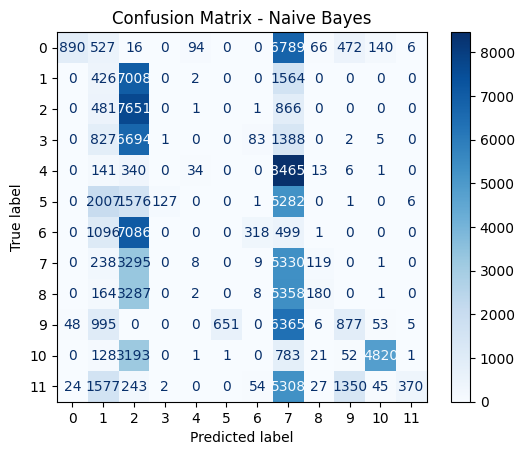

              precision    recall  f1-score   support

           0       0.93      0.10      0.18      9000
           1       0.05      0.05      0.05      9000
           2       0.19      0.85      0.31      9000
           3       0.01      0.00      0.00      9000
           4       0.24      0.00      0.01      9000
           5       0.00      0.00      0.00      9000
           6       0.67      0.04      0.07      9000
           7       0.11      0.59      0.19      9000
           8       0.42      0.02      0.04      9000
           9       0.32      0.10      0.15      9000
          10       0.95      0.54      0.69      9000
          11       0.95      0.04      0.08      9000

    accuracy                           0.19    108000
   macro avg       0.40      0.19      0.15    108000
weighted avg       0.40      0.19      0.15    108000



In [17]:
# Naive Bayes
start_train = time.time()

nb = GaussianNB()
nb.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Naive Bayes): {training_time:.4f} detik")

evaluate_model(nb, X_test, y_test, name="Naive Bayes")

##### Decision Tree

Waktu pelatihan (Decision Tree): 3.7920 detik
Waktu prediksi (Decision Tree): 0.0560 detik


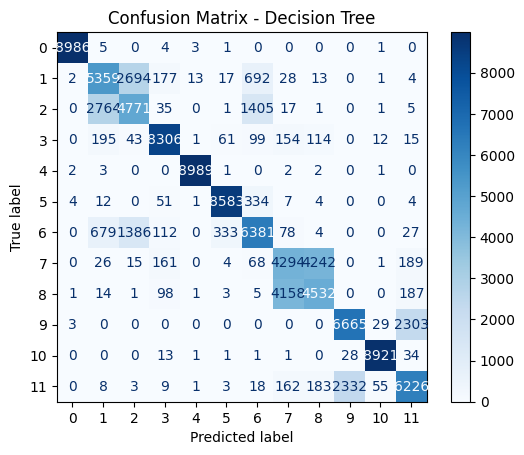

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.59      0.60      0.59      9000
           2       0.54      0.53      0.53      9000
           3       0.93      0.92      0.92      9000
           4       1.00      1.00      1.00      9000
           5       0.95      0.95      0.95      9000
           6       0.71      0.71      0.71      9000
           7       0.48      0.48      0.48      9000
           8       0.50      0.50      0.50      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.69      0.69      0.69      9000

    accuracy                           0.76    108000
   macro avg       0.76      0.76      0.76    108000
weighted avg       0.76      0.76      0.76    108000



In [18]:
# Decision Tree
start_train = time.time()

dt = DecisionTreeClassifier()
dt = dt.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Decision Tree): {training_time:.4f} detik")

evaluate_model(dt, X_test, y_test, name="Decision Tree")

##### Random Forest

Waktu pelatihan (Random Forest): 46.0410 detik
Waktu prediksi (Random Forest): 2.5726 detik


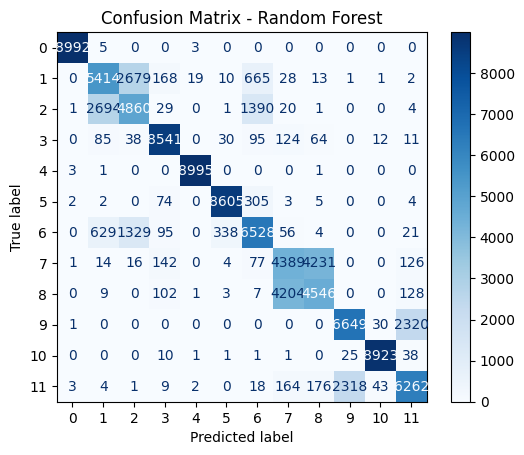

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.61      0.60      0.61      9000
           2       0.54      0.54      0.54      9000
           3       0.93      0.95      0.94      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.96      0.96      9000
           6       0.72      0.73      0.72      9000
           7       0.49      0.49      0.49      9000
           8       0.50      0.51      0.50      9000
           9       0.74      0.74      0.74      9000
          10       0.99      0.99      0.99      9000
          11       0.70      0.70      0.70      9000

    accuracy                           0.77    108000
   macro avg       0.77      0.77      0.77    108000
weighted avg       0.77      0.77      0.77    108000



In [19]:
# Random Forest
start_train = time.time()

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (Random Forest): {training_time:.4f} detik")

evaluate_model(rf, X_test, y_test, name="Random Forest")

##### XGBoost

Waktu pelatihan (XGBoost): 9.3100 detik
Waktu prediksi (XGBoost): 0.2060 detik


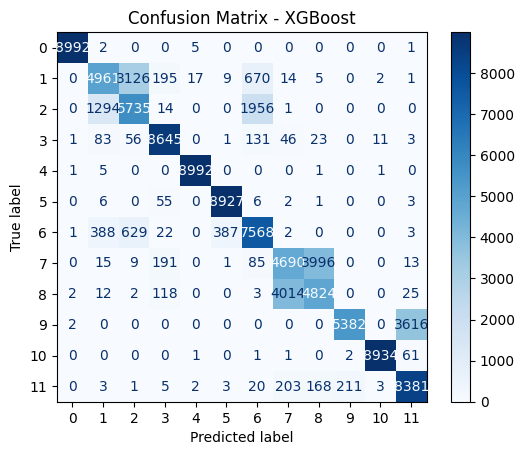

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9000
           1       0.73      0.55      0.63      9000
           2       0.60      0.64      0.62      9000
           3       0.94      0.96      0.95      9000
           4       1.00      1.00      1.00      9000
           5       0.96      0.99      0.97      9000
           6       0.72      0.84      0.78      9000
           7       0.52      0.52      0.52      9000
           8       0.53      0.54      0.54      9000
           9       0.96      0.60      0.74      9000
          10       1.00      0.99      1.00      9000
          11       0.69      0.93      0.79      9000

    accuracy                           0.80    108000
   macro avg       0.80      0.80      0.79    108000
weighted avg       0.80      0.80      0.79    108000



In [20]:
# XGBoost
start_train = time.time()

xgBoost = xgb.XGBClassifier(tree_method="hist")
xgBoost.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (XGBoost): {training_time:.4f} detik")

evaluate_model(xgBoost, X_test, y_test, name="XGBoost")

##### AdaBoost

Waktu pelatihan (AdaBoost): 17.1759 detik
Waktu prediksi (AdaBoost Classifier): 1.1722 detik


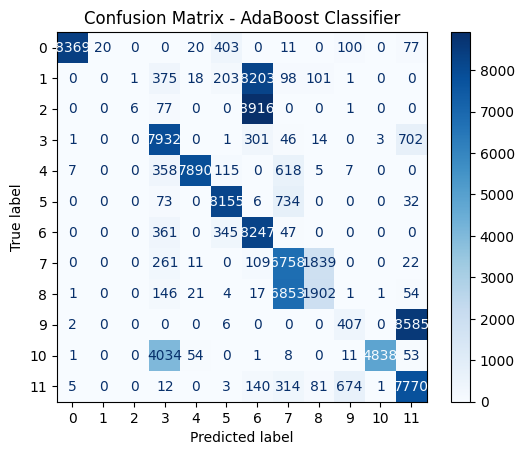

              precision    recall  f1-score   support

           0       1.00      0.93      0.96      9000
           1       0.00      0.00      0.00      9000
           2       0.86      0.00      0.00      9000
           3       0.58      0.88      0.70      9000
           4       0.98      0.88      0.93      9000
           5       0.88      0.91      0.89      9000
           6       0.32      0.92      0.47      9000
           7       0.44      0.75      0.55      9000
           8       0.48      0.21      0.29      9000
           9       0.34      0.05      0.08      9000
          10       1.00      0.54      0.70      9000
          11       0.45      0.86      0.59      9000

    accuracy                           0.58    108000
   macro avg       0.61      0.58      0.51    108000
weighted avg       0.61      0.58      0.51    108000



In [ ]:
# AdaBoost
start_train = time.time()

adc = AdaBoostClassifier(random_state=42)
adc.fit(X_train, y_train)

end_train = time.time()
training_time = end_train - start_train
print(f"Waktu pelatihan (AdaBoost): {training_time:.4f} detik")

evaluate_model(adc, X_test, y_test, name="AdaBoost Classifier")